In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
fig_scale = 1.#2./3.

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time
import json

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [4]:
plt.rcParams['font.size'] = 14

In [5]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[CpuDevice(id=0)]


# Process Data

In [6]:
c_df, r_df, d_df = transform.IRD(min_confirmed=0, min_recovered=0, min_deaths=20)
c_df.columns = pd.to_datetime(c_df.columns)
d_df.columns = pd.to_datetime(d_df.columns)

[265, 252, 91]


In [7]:
t_df, h_df, w_df = transform.weather(update=False)

In [8]:
d_df

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,30,30,30,33,36,36,40,42,43,47
Albania,0,0,0,0,0,0,0,0,0,0,...,26,26,26,26,26,26,27,27,27,27
Algeria,0,0,0,0,0,0,0,0,0,0,...,348,364,367,375,384,392,402,407,415,419
Andorra,0,0,0,0,0,0,0,0,0,0,...,33,35,35,36,37,37,37,37,40,40
Argentina,0,0,0,0,0,0,0,0,0,0,...,115,123,129,132,136,147,152,165,176,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
US,0,0,0,0,0,0,0,0,0,0,...,32930,36787,38664,40661,42094,44444,46622,49954,51949,53755
Mali,0,0,0,0,0,0,0,0,0,0,...,13,13,13,14,14,14,17,21,21,21
Australia,0,0,0,0,0,0,0,0,0,0,...,63,66,67,67,67,67,67,75,79,80


In [9]:
cases = {}
deaths = {}
temps = {}
hums = {}
start_days = np.argmax((d_df.values>3),axis=1)
end_days = np.argmax((d_df.values>1000), axis=1)
for i, country in enumerate(d_df.index):
    climate_delay = 28    # days between infection and death
    if start_days[i]<climate_delay:
        climate_delay = start_days[i]
    if len(d_df.T[country].values[start_days[i]:])>10 and start_days[i]>0:
        if end_days[i]>0:
            time_slice = slice(start_days[i]-climate_delay, end_days[i]-climate_delay)
            temps[country] = np.nanmean(t_df.T[country].values[time_slice])
            hums[country] = np.nanmean(h_df.T[country].values[time_slice])
            cases[country] = c_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:end_days[i]]].T[country].values
        else:
            temps[country] = np.nanmean(t_df.T[country].values[start_days[i]-climate_delay:])
            hums[country] = np.nanmean(h_df.T[country].values[start_days[i]-climate_delay:])
            cases[country] = c_df[d_df.columns[start_days[i]:]].T[country].values
            deaths[country] = d_df[d_df.columns[start_days[i]:]].T[country].values

In [10]:
len(deaths)

89

In [11]:
samples = {}
with h5py.File('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]
countries = onp.loadtxt('../data/nb_samples/4.1.0.1_STEP_EXP_Independent_countries.txt', 
                        delimiter='|', dtype=str)[:,0]

t0 = np.mean(samples['t0'], axis=0)

t0_dict = dict(zip(countries, t0.astype(np.int32)))

In [12]:
# Ecuador shows to have greater than 100% positive rate. MORE POSITIVES than TESTS
all_countries = list(set(deaths.keys()).intersection(countries[t0>10]) - set(['Ecuador']))

In [13]:
len(all_countries)

65

In [14]:
bcg_cov_est = json.load(open('BCG_Coverage_Estimates.json', 'r'))

In [15]:
print(f'Missing BCG Coverage for : {set(all_countries)-set(bcg_cov_est.keys())}')
all_countries = list(set(all_countries).intersection(bcg_cov_est.keys()))

Missing BCG Coverage for : {'Congo (Kinshasa)', 'San Marino', 'Moldova', 'Bolivia'}


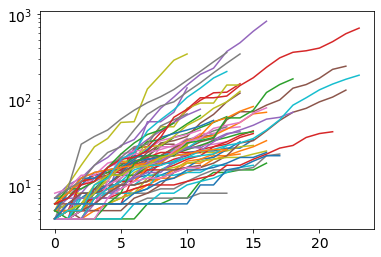

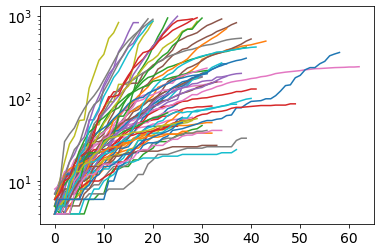

In [16]:
for c in all_countries:
    plt.semilogy(deaths[c][:t0_dict[c]])
plt.figure()
for c in all_countries:
    plt.semilogy(deaths[c])

In [17]:
len(all_countries)

61

In [18]:
blood_df = pd.read_csv('../data/blood/blood_type.csv', index_col='Country')

aus = ['Australia / New South Wales']
canada = ['Canada / Alberta', 'Canada / British Columbia', 
          'Canada / Ontario', 'Canada / Quebec']
china = ['China / Henan', 'China / Hubei']
DEAD = ['Czechia', 'Congo (Kinshasa)', 'Korea, South', 
        'Luxembourg', 'North Macedonia', 'Moldova', 'US']
BLOOD = ['Czech Republic', 'Democratic Republic of the Congo', 'Korea', 
         'Luxemburg', 'Macedonia', 'Republic of Moldova', 'United States']
aplus = {}
for c in blood_df.T:
    if c in d_df.index:
        aplus[c] = blood_df['A+'][c]
    elif (c in BLOOD):
        idx = np.where(onp.array(BLOOD)==c)[0][0]
        aplus[DEAD[idx]] = blood_df['A+'][c]
        
for c in aus:
    aplus[c] = aplus['Australia']
for c in canada:
    aplus[c] = aplus['Canada']
for c in china:
    aplus[c] = aplus['China']

In [19]:
set(all_countries) - set(aplus.keys())

{'Afghanistan',
 'Algeria',
 'Andorra',
 'Belarus',
 'Burkina Faso',
 'Panama',
 'Tunisia'}

In [20]:
all_countries = list(set(all_countries).intersection(aplus.keys()))

In [21]:
theta = {}
for c in all_countries:
    theta[c] = np.array([bcg_cov_est[c], temps[c], hums[c], aplus[c]])

In [22]:
len(all_countries), len(theta)

(54, 54)

In [28]:
with h5py.File('../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    countries = fp['countries'][()]

In [31]:
all_countries = [c.decode() for c in countries]

# Bayesian Model

In [31]:
def normalHP(name, mean, std, N_child):

    # Group mean
    grp_mean = numpyro.sample(str(name)+'_grp_mean', dist.Normal(mean, std))
    # Group variance
    grp_sigma = numpyro.sample(str(name)+'_grp_sigma', dist.HalfNormal(std))
    # Individual param
    ind = numpyro.sample(str(name)+'_ind', 
                         dist.TransformedDistribution(dist.Normal(0.0*np.ones(N_child), 1.0*np.ones(N_child)), 
                                                      dist.transforms.AffineTransform(grp_mean, grp_sigma)))
#     ind = numpyro.sample(str(name)+'_ind', dist.Normal(grp_mean*np.ones(N_child), grp_sigma*np.ones(N_child)))
    
    return ind

In [32]:
def model():
    
    N = len(all_countries)
    N_theta = len(theta[list(theta.keys())[0]])
    
    Di = normalHP('Di', 7.0, 3.0, N)
    GR = normalHP('GR', 1.2, 0.2, N)
    
    # Coefficients / Weights
    W = numpyro.sample('W', dist.Normal(0.0*np.ones(N_theta), 0.01*np.ones(N_theta)))

    # Create likelihood for each country    
    for i, country in enumerate(all_countries):
        dead = deaths[country][:t0_dict[country]]
        t = np.arange(len(dead))
        correction = np.dot(W, theta[country])
        prediction = Di[i]*(GR[i]+correction)**t
        numpyro.sample(country, dist.Poisson(prediction), # Exponential regression
                       obs=dead)

In [33]:
N = len(all_countries)
N_theta = len(theta[list(theta.keys())[0]])

scale = 0.5

init_params = {'Di_grp_mean': 7.0*np.ones((N_chains, 1)) + 3.0*scale*onp.random.randn(N_chains, 1),
               'GR_grp_mean': 1.2*np.ones((N_chains, 1)) + 0.2*scale*onp.random.randn(N_chains, 1),
               'Di_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'GR_grp_sigma': 0.0*np.ones((N_chains, 1)) + 0.1*np.abs(scale*onp.random.randn(N_chains, 1)),
               'Di_ind': 7.0*np.ones((N_chains, N)) + 3.0*scale*onp.random.randn(N_chains, N),
               'GR_ind': 1.2*np.ones((N_chains, N)) + 0.2*scale*onp.random.randn(N_chains, N),
               'W': 0.0*np.ones((N_chains, N_theta)) + 0.01*scale*onp.random.randn(N_chains, N_theta)
              }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=10000, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [34]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(f'Time taken to compile model and draw samples : {time()-s} s')

Time taken to compile model and draw samples : 25201.65370130539 s


In [35]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/4.1.1.9.2_EXCL_TESTS_MultiVariate_Regression_samples.h5', 'w') as fp:
    for key in samples.keys():
        fp[key] = samples[key]
    fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
    fp['countries'] = [c.encode() for c in all_countries]
mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 Di_grp_mean[0]      5.64      0.37      5.64      5.03      6.24   3586.02      1.00
Di_grp_sigma[0]      2.21      0.30      2.19      1.73      2.69   7871.28      1.00
      Di_ind[0]      8.44      0.73      8.42      7.26      9.67  45102.51      1.00
      Di_ind[1]      4.86      0.59      4.83      3.87      5.77  39498.49      1.00
      Di_ind[2]      3.81      0.62      3.78      2.82      4.85  21484.85      1.00
      Di_ind[3]      6.90      0.52      6.88      6.04      7.75  57472.24      1.00
      Di_ind[4]      3.72      0.71      3.67      2.53      4.84  26347.06      1.00
      Di_ind[5]      7.00      0.88      6.95      5.52      8.40  28833.93      1.00
      Di_ind[6]      3.33      0.63      3.28      2.28      4.33  36532.95      1.00
      Di_ind[7]      5.01      0.74      4.97      3.77      6.18  32871.43      1.00
      Di_ind[8]      4.71      0.92      4.65      3.

In [27]:
# samples = mcmc.get_samples()
# with h5py.File('../data/nb_samples/4.1.1.9.1_EXCL_TESTS_MultiVariate_Regression_samples.h5', 'w') as fp:
#     for key in samples.keys():
#         fp[key] = samples[key]
#     fp['potential_energy'] = mcmc.get_extra_fields()['potential_energy']
#     fp['countries'] = [c.encode() for c in all_countries]
# mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
 Di_grp_mean[0]      5.63      0.30      5.62      5.14      6.11   6636.50      1.00
Di_grp_sigma[0]      1.98      0.23      1.97      1.60      2.35   7902.44      1.00
      Di_ind[0]      4.82      0.63      4.79      3.78      5.83   5319.24      1.00
      Di_ind[1]      4.89      0.73      4.86      3.69      6.09   1673.98      1.00
      Di_ind[2]      5.30      0.90      5.25      3.82      6.77   1877.32      1.00
      Di_ind[3]      6.86      0.52      6.85      6.00      7.70  20710.03      1.00
      Di_ind[4]      6.30      0.96      6.25      4.77      7.91   1670.62      1.00
      Di_ind[5]      5.59      0.82      5.54      4.25      6.94   1102.74      1.00
      Di_ind[6]      5.26      0.90      5.21      3.81      6.73   3496.65      1.00
      Di_ind[7]      3.96      0.58      3.93      2.99      4.88   5912.17      1.00
      Di_ind[8]      4.77      0.91      4.72      3.

Number of divergences: 0


In [33]:
samples = {}
with h5py.File('../data/nb_samples/4.1.1.9.2_EXCL_TESTS_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

In [34]:
THETA = np.array([theta[c] for c in theta])

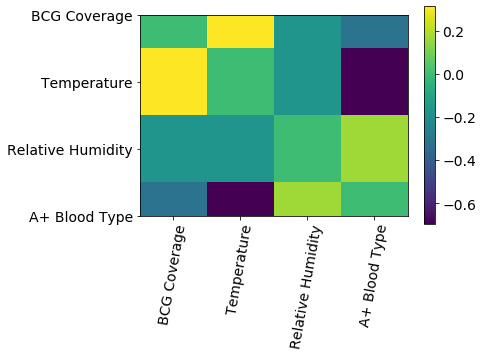

In [35]:
# plt.figure(figsize=(7,10))
cov = np.cov(THETA.T)
corr = cov/np.sqrt((np.diag(cov)[None,:]*np.diag(cov)[:,None]))
corr -= np.eye(len(corr))
plt.imshow(corr)
plt.colorbar()
plt.xticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
                                  'Relative Humidity', 'A+ Blood Type'],
          rotation=80)

plt.yticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
                                  'Relative Humidity', 'A+ Blood Type'],
          rotation=0);

In [36]:
# # plt.figure(figsize=(7,10))
# cov = np.cov(THETA.T)
# corr = cov/np.sqrt((np.diag(cov)[None,:]*np.diag(cov)[:,None]))
# corr -= np.eye(len(corr))
# plt.imshow(corr)
# plt.colorbar()
# plt.xticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
#                                   'Relative Humidity', 'Tests per 1k', 
#                                   'Positive Rate', 'A+ Blood Type'],
#           rotation=80)

# plt.yticks(np.arange(len(corr)), ['BCG Coverage', 'Temperature', 
#                                   'Relative Humidity', 'Tests per 1k', 
#                                   'Positive Rate', 'A+ Blood Type'],
#           rotation=0);

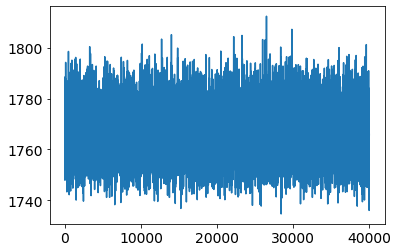

In [37]:
plt.plot(samples['potential_energy'])

In [38]:
float(np.min(samples['potential_energy'])), float(np.mean(samples['potential_energy'])), float(np.max(samples['potential_energy']))

(1734.6116943359375, 1766.6083984375, 1812.4754638671875)

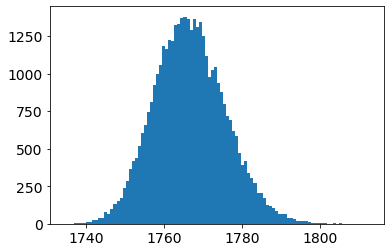

In [39]:
plt.hist(samples['potential_energy'], bins=100);

# Evidence Calculation

### Bayes Rule and Evidence

$m$: model, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\mathbf{y}$: dataset, &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\Theta_m$: parameters of model $m$

$$P(\Theta_m | \mathbf{y}, m) = \frac{P(\mathbf{y}|\Theta_m, m) P(\Theta_m | m)}{P(\mathbf{y} | m)}$$

### The Laplace Approximation

Let the posterior be approximated by a $d$-dimensional multivariate normal distribution. $m$, $\mathbf{y}$ and $\hat{\Theta}_m$ will denote the model, data set, MAP estimate respectively.

$$P(\Theta_m | \mathbf{y}, m) \approx (2\pi)^{-\frac{d}{2}} |\Sigma|^{-\frac{1}{2}} \exp\big[ -\frac{1}{2} (\Theta_m - \hat{\Theta}_m)^T \Sigma^{-1} (\Theta_m - \hat{\Theta}_m) \big] $$

$$P(\mathbf{y} | m) = \frac{P(\Theta_m, \mathbf{y} | m)}{P(\Theta_m | \mathbf{y}, m)}$$

$$\implies \ln P(\mathbf{y} | m) \approx \ln P(\hat{\Theta}_m | m) + \ln P(\mathbf{y} | \hat{\Theta}_m, m) + 
   \frac{d}{2}\ln 2\pi + \frac{1}{2}\ln |\Sigma|$$

In [40]:
all_samples = np.concatenate([samples[key] for key in samples if key not in ['countries', 'potential_energy']], axis=1)

In [45]:
x = onp.random.randn(2,3)
x.shape, np.cov(x).shape

((2, 3), (2, 2))

In [55]:
[key for key in samples if key not in ['countries', 'potential_energy']]

['Di_grp_mean',
 'Di_grp_sigma',
 'Di_ind',
 'GR_grp_mean',
 'GR_grp_sigma',
 'GR_ind',
 'W']

In [56]:
samples['GR_ind'].shape[1]

40

In [41]:
all_samples.shape

(40000, 88)

In [67]:
min_idx = np.argmin(samples['potential_energy'])
log_p_plus_log_l = onp.array(samples['potential_energy'][min_idx])
all_samples = onp.concatenate([samples[key] for key in samples if key not in ['countries', 'potential_energy']], axis=1)
cov = onp.cov(all_samples.T)
d = len(cov)

In [73]:
onp.log(onp.linalg.det(cov))

-516.0201239848254

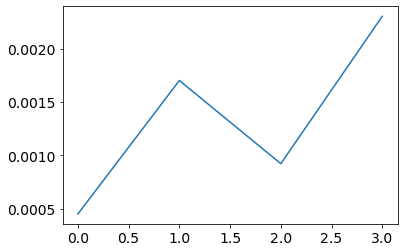

In [69]:
plt.plot(np.sqrt(np.diag(cov)[-4:]))

In [63]:
np.std(samples['W'], axis=0)

DeviceArray([0.00044939, 0.00170252, 0.0009213 , 0.0023061 ], dtype=float32)

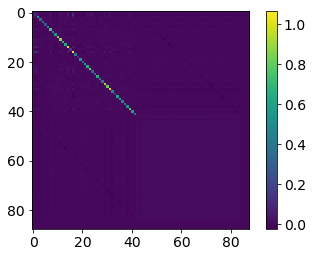

In [88]:
plt.imshow((cov))
plt.colorbar()

In [84]:
all_samples = onp.concatenate([samples[key] for key in samples if key not in ['countries', 'potential_energy']], axis=1)

In [86]:
cov = onp.cov(all_samples.T)

In [90]:
D, Q = onp.linalg.eigh(cov)

In [93]:
onp.sum(onp.log(D))

-516.0201239859043

In [103]:
def log_evidence(samples):
    log_p_plus_log_l = onp.min(samples['potential_energy'])
    all_samples = onp.concatenate([samples[key] for key in samples if key not in ['countries', 'potential_energy']], axis=1)
    
    cov = onp.cov(all_samples.T)
    d = len(cov)
    D, Q = onp.linalg.eigh(cov)
    log_post = d*onp.log(2*onp.pi)/2. + onp.sum(onp.log(D))/2.
#     log_post = d*onp.log(2*onp.pi)/2. + onp.log(onp.linalg.det(cov))/2.
    return log_p_plus_log_l + log_post

In [100]:
samples_excl_test = {}
with h5py.File('../data/nb_samples/4.1.1.9.2_EXCL_TESTS_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples_excl_test[key] = fp[(key)][()]

In [101]:
log_evidence(samples_excl_test)

1557.468223265536

In [104]:
log_evidence(samples_excl_test)

1557.4682232649966

In [81]:
samples_incl_test = {}
with h5py.File('../data/nb_samples/4.1.1.8.4_INCL_BLOOD_MultiVariate_Regression_samples.h5', 'r') as fp:
    for key in fp.keys():
        samples_incl_test[key] = fp[(key)][()]

In [105]:
log_evidence(samples_excl_test)-log_evidence(samples_incl_test)

20.550812362931538

In [106]:
log_evidence(samples_incl_test)-log_evidence(samples_excl_test)

-20.550812362931538

# Trace Plots

In [36]:
autos = numpyro.diagnostics.autocorrelation(samples['W'])

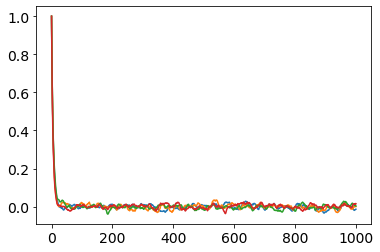

In [37]:
plt.plot(autos[:1000]);

In [51]:
autos.shape

(40000, 4)

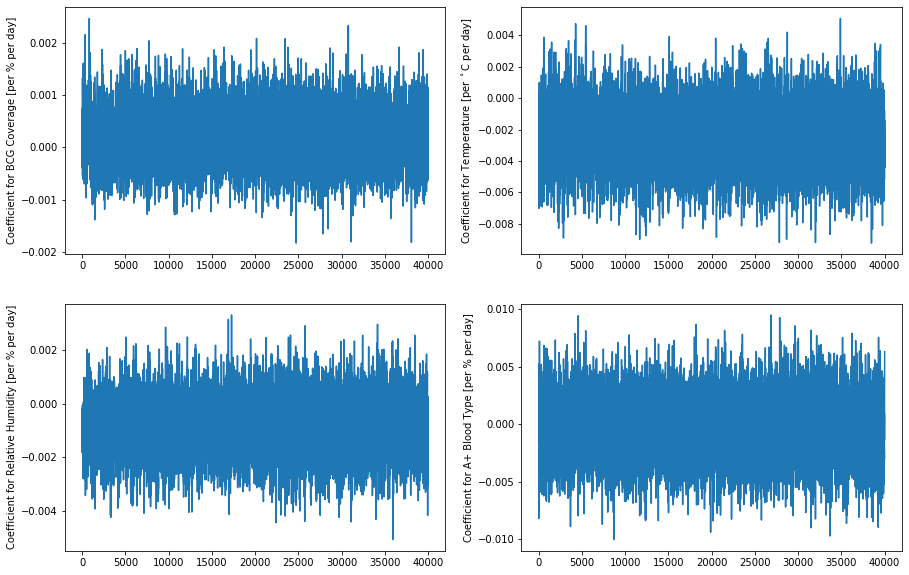

In [38]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][:,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

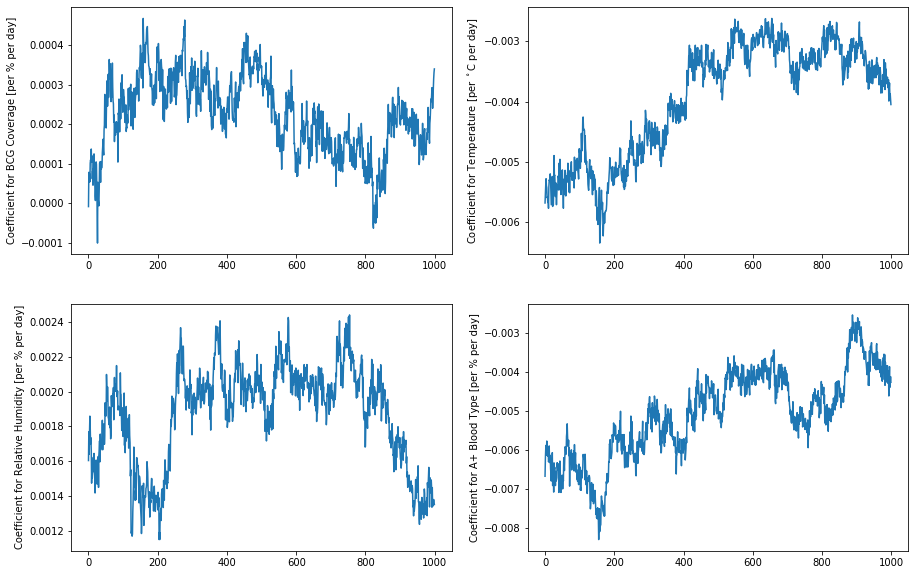

In [33]:
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '%']
for i in range(N_theta):
    a[i].plot(samples['W'][:,i])
    a[i].set_ylabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

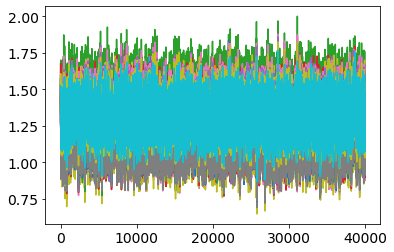

In [58]:
plt.plot(samples['GR_ind']);

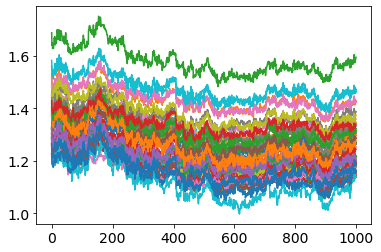

In [34]:
plt.plot(samples['GR_ind']);

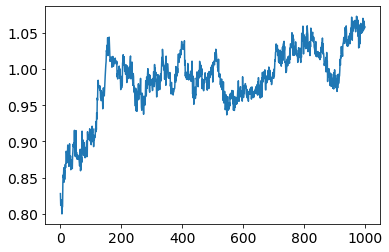

In [35]:
plt.plot(samples['GR_grp_mean'])

# Parameter Marginals

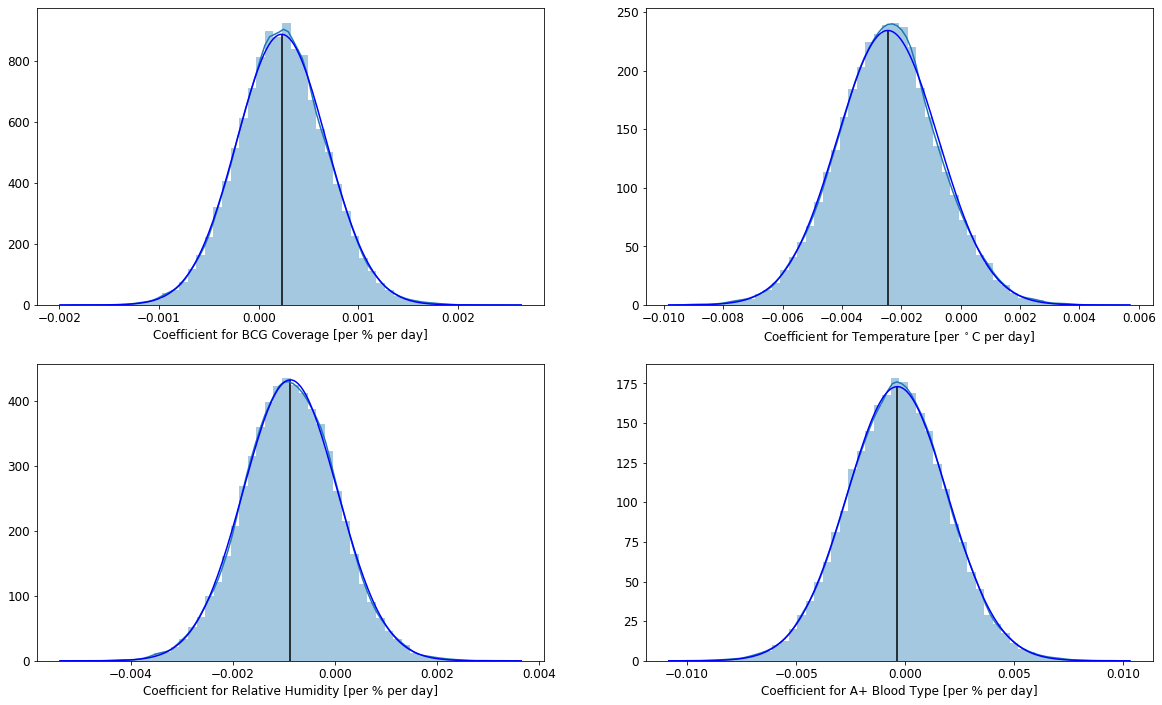

In [41]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '%', '%']
for i in range(N_theta):
    sns.distplot(samples['W'][:,i], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples['W'][:,i]), 0, norm.pdf(np.mean(samples['W'][:,i]), *norm.fit(samples['W'][:,i])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

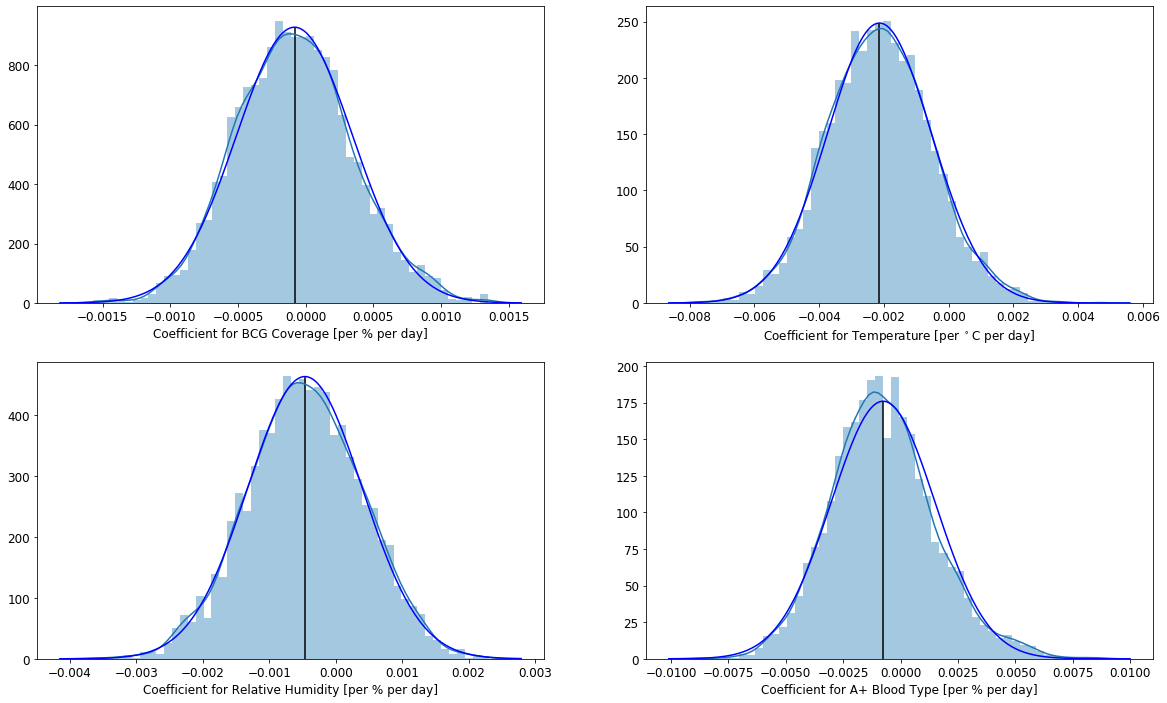

In [48]:
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
a = ax.flatten()
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '%', '%']
for i in range(N_theta):
    sns.distplot(samples['W'][good_samples,i], bins=50, fit=norm, ax = a[i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    a[i].vlines(np.mean(samples['W'][good_samples,i]), 0, norm.pdf(np.mean(samples['W'][good_samples,i]), *norm.fit(samples['W'][good_samples,i])))
    a[i].set_xlabel(f'Coefficient for {param_name[i]} [per {param_units[i]} per day]')
plt.rcParams['font.size'] = 14

In [38]:
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 'A+ Blood Type']
coeff_df = pd.DataFrame(samples['W'][10000:20000], columns=param_name) 

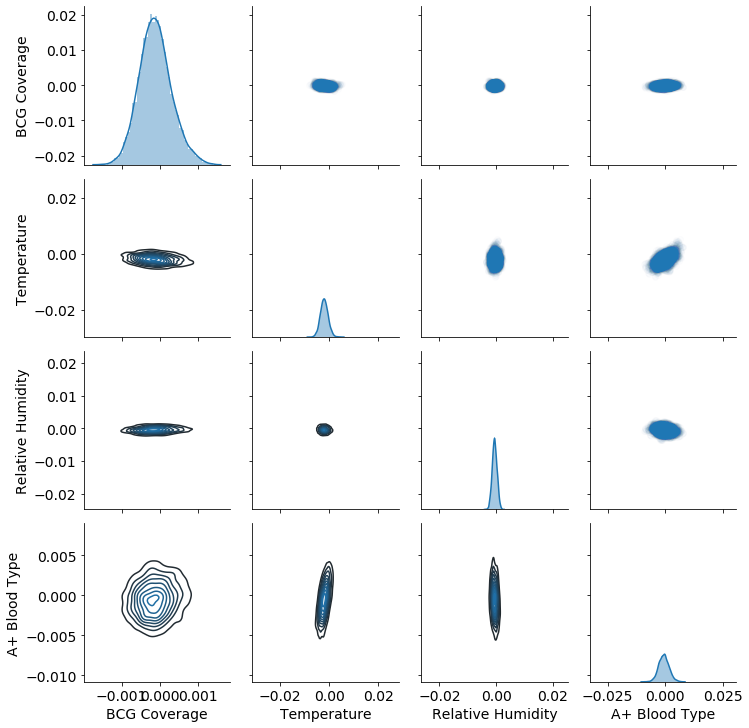

In [39]:
g = sns.PairGrid(coeff_df)
g.map_upper(plt.scatter, alpha=0.01)
g.map_lower(sns.kdeplot)
# g.map_diag(sns.kdeplot, lw=3, legend=False);
g.map_diag(sns.distplot)

In [41]:
np.abs(np.mean(samples['W'], axis=0)/np.std(samples['W'], axis=0))

DeviceArray([0.1974566 , 1.32736   , 0.5465241 , 0.32992366], dtype=float32)

In [161]:
list(zip(np.mean(samples['W'], axis=0), np.std(samples['W'], axis=0)))

[(4.2403386e-05, 0.00038725897),
 (-0.0033650969, 0.0014911207),
 (-0.0012965329, 0.00077395746),
 (-0.00093372806, 0.0011650125),
 (0.0027515374, 0.0008305063),
 (-0.0012630529, 0.0020272466)]

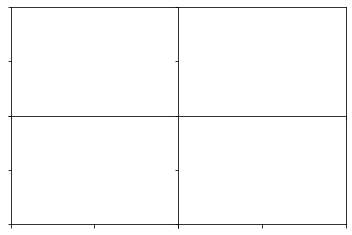

In [95]:
fig, ax = plt.subplots(2,2)

for a in ax.flatten():
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [124]:
%env JAX_ENABLE_X64=True

env: JAX_ENABLE_X64=True


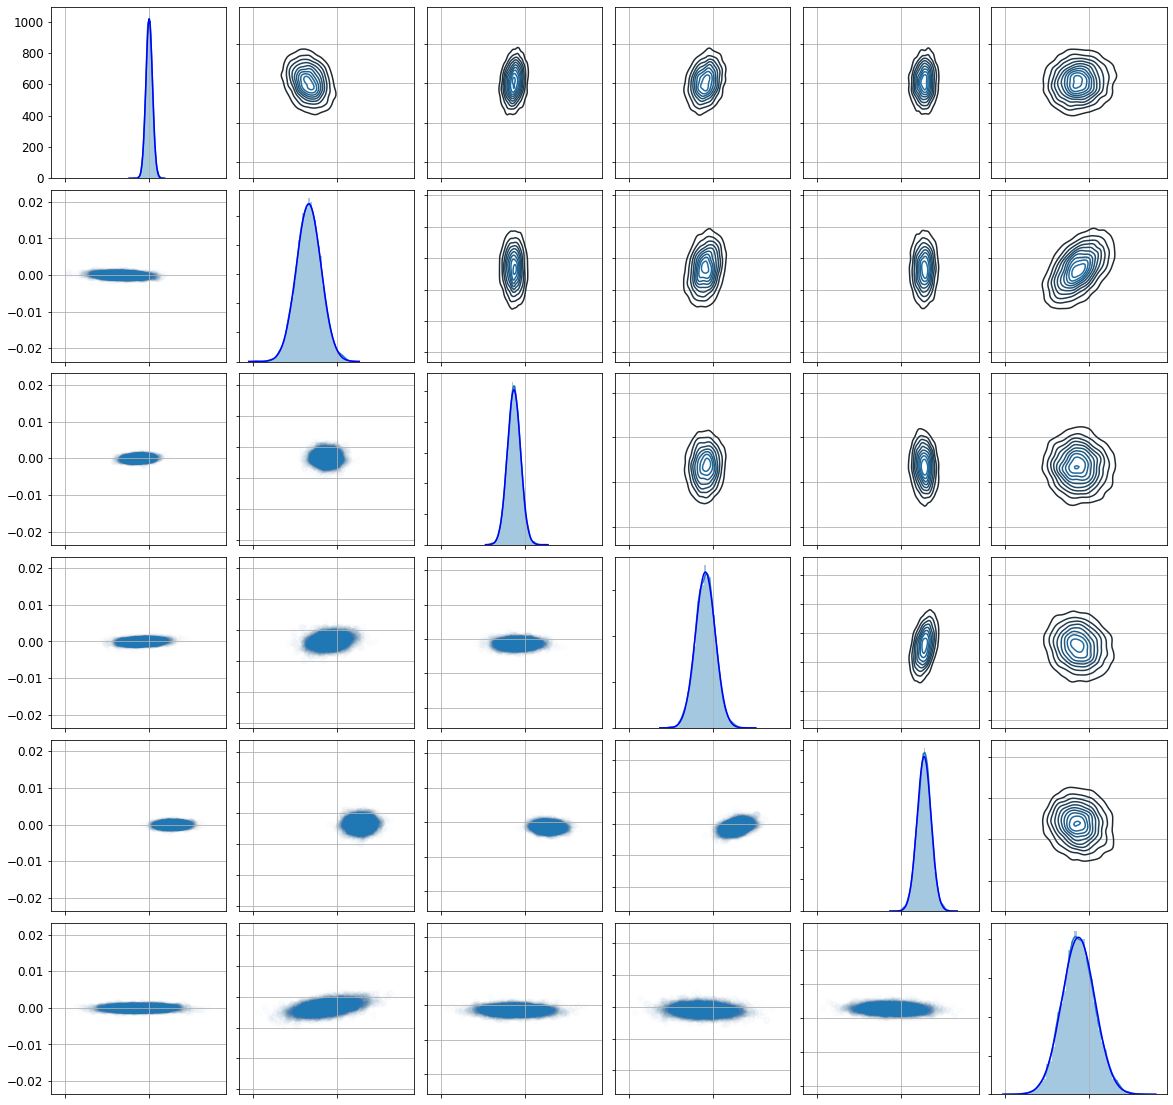

In [159]:
N_samples = 10000
plt.rcParams['font.size'] = 12
plot_space = 0.07
fig, ax = plt.subplots(6, 6, figsize=(20,20), sharex=True)
param_name = ['BCG Coverage', 'Temperature', 'Relative Humidity', 
              'Tests per 1k', 'Positive Rate', 'A+ Blood Type']
param_units = ['%', r'$^\circ$C', '%', '(test/1k)', '%', '%']

# Diagnonal
for i in range(N_theta):
    sns.distplot(samples['W'][:N_samples,i], bins=50, fit=norm, ax = ax[i,i],
                 fit_kws={'color':'blue'}, color='tab:blue', label=param_name[i])
    ax[i,i].grid(axis='x')
        
idx = np.triu_indices(N_theta, 1)

# Upper Triangle
for i, a in enumerate(ax[idx[0], idx[1]]):
    a.grid()
    sns.kdeplot(samples['W'][:N_samples,idx[1][i]], samples['W'][:N_samples,idx[0][i]], ax=a)
#     ax[i,i].set_yticklabels([])

# Lower Triangle
for i, a in enumerate(ax[idx[1], idx[0]]):
    a.grid()
    a.scatter(samples['W'][:N_samples,idx[1][i]], samples['W'][:N_samples,idx[0][i]], 
              color='tab:blue', alpha=0.01)
#     sns.kdeplot(samples['W'][:N_samples,idx[1][i]], samples['W'][:N_samples,idx[0][i]], ax=a)


# ax[0,0].set_yticklabels(ax[1,0].get_yticks())

for a in ax[:,1:].flatten():
    a.set_yticklabels([])
for a in ax[:-1,:].flatten():
    a.set_xticklabels([])

    
plt.subplots_adjust(wspace=plot_space, hspace=plot_space)
plt.rcParams['font.size'] = 14

In [43]:
import corner

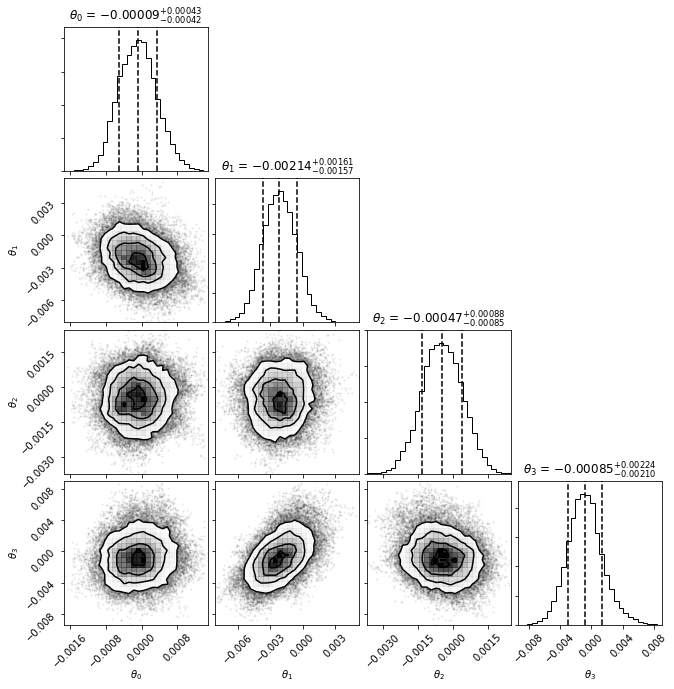

In [70]:
plt.rcParams['font.size'] = 10
param_data = ['BCG Coverage', 'Temperature', 'Relative Humidity','A+ Blood Type']
param_name = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$',
              r'$\theta_3$']
fig = corner.corner(samples['W'], labels=param_name,
                       quantiles=[0.16, 0.5, 0.84], bins=30, title_fmt='.5f',
                       show_titles=True, title_kwargs={"fontsize": 12})

# line = sns.kdeplot(samples['W'][:10,0], color='k')
# fig.legend(handles=[line for _ in range(N_theta)], 
#            labels=[f'{param_name[i]} := {param_data[i]}' for i in range(N_theta)])

plt.savefig('../plots/4.1.1.9_BCG_Climate_Blood_Corner_Plot.png', dpi=300)
plt.rcParams['font.size'] = 14

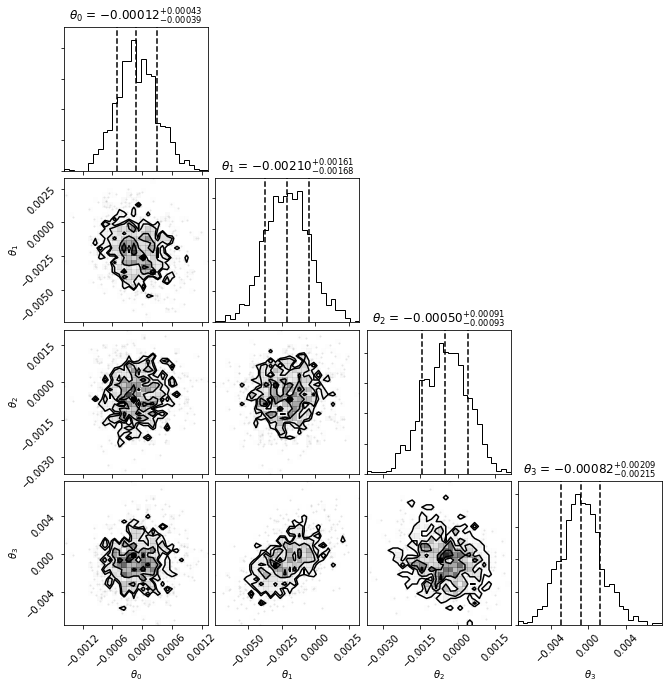

In [67]:
plt.rcParams['font.size'] = 10
param_data = ['BCG Coverage', 'Temperature', 'Relative Humidity','A+ Blood Type']
param_name = [r'$\theta_0$', r'$\theta_1$', r'$\theta_2$',
              r'$\theta_3$']
fig = corner.corner(samples['W'][good_samples], labels=param_name,
                       quantiles=[0.16, 0.5, 0.84], bins=30, title_fmt='.5f',
                       show_titles=True, title_kwargs={"fontsize": 12})

# line = sns.kdeplot(samples['W'][:10,0], color='k')
# fig.legend(handles=[line for _ in range(N_theta)], 
#            labels=[f'{param_name[i]} := {param_data[i]}' for i in range(N_theta)])
plt.rcParams['font.size'] = 14

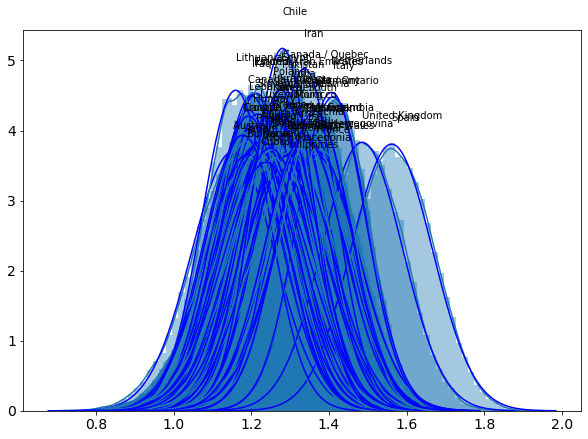

In [46]:
plt.figure(figsize=(fig_scale*10,fig_scale*7))
for i, c in enumerate(all_countries):
    mn = np.mean(samples['GR_ind'][:,i])
    std = np.std(samples['GR_ind'][:,i])
    plt.text(mn, 1.1*norm.pdf(mn, mn, std), c, fontsize=10, verticalalignment='center')
    sns.distplot(samples['GR_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'blue'}, color='tab:blue')

# Example Plots

IndexError: index 49 is out of bounds for axis 0 with size 49

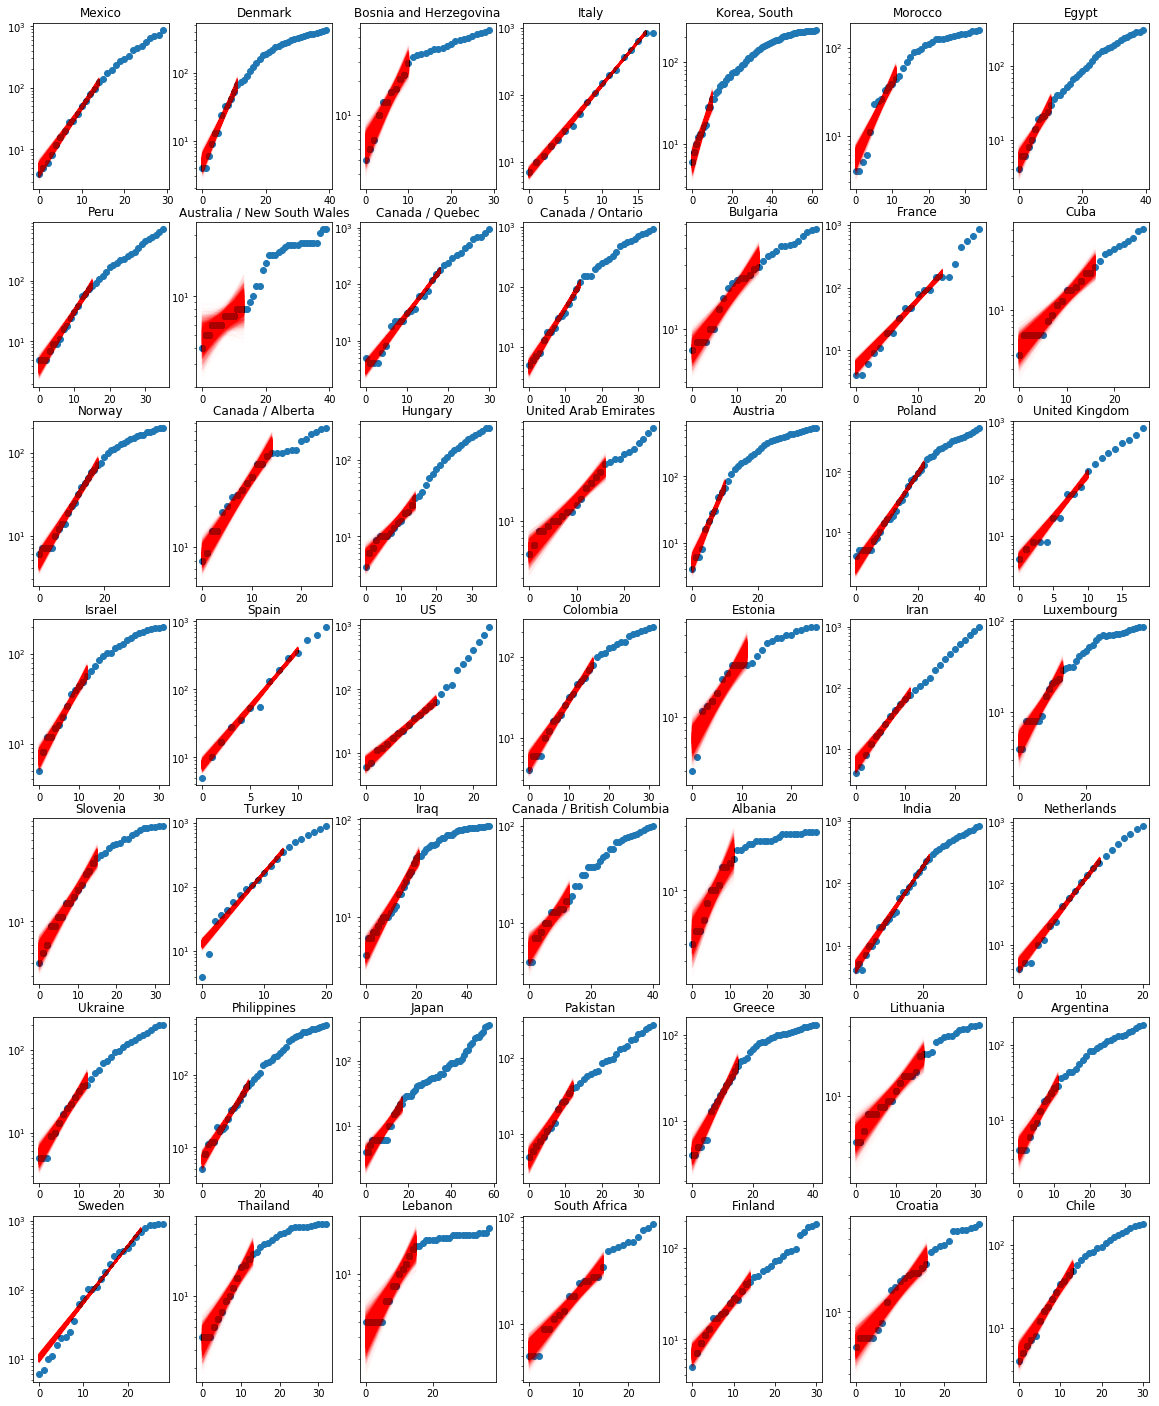

In [47]:
plt.rcParams['font.size'] = 10
fig,ax = plt.subplots(7, 7, figsize=(fig_scale*20,fig_scale*25))
a = ax.flatten()
for i, c in enumerate(all_countries):
    a[i].set_title(c)
    a[i].semilogy(deaths[c], 'o')
    dead = deaths[c]
    t = np.arange(len(dead))[:t0_dict[c]]
    correction = np.dot(samples['W'][::10,:], theta[c])[:,None]
    prediction = samples['Di_ind'][::10,i,None]*(samples['GR_ind'][::10,i,None]+correction)**t[None,:]
    a[i].semilogy(prediction.T, 'r', alpha=0.01)
    
# plt.savefig('../plots/4.1_ExampleFits.png', dpi=200)     
plt.rcParams['font.size'] = 14

In [35]:
Tsys = 16                 # Kelvin
A = np.pi*(13.5/2)**2     # Metres^2
eta = 1.0                 # Dimensionless
delta_nu = 208.984e3      # Hz
tau = 8                   # Seconds
Kb = 1.3806503e-23        # Joules/Kelvin

In [36]:
noise = Tsys*Kb/(A*eta)*np.sqrt(2/(delta_nu*tau))    # J/m^2   ->  W/m^2/Hz

In [37]:
noiseJy = noise*1e26                                 # Jy

In [42]:
print(f'The noise per visibility voxel for an {tau} second dump ')
print(f'and a single channel of width {delta_nu} Hz ')
print(f'is {noiseJy} Jy')

The noise per visibility voxel for an 8 second dump 
and a single channel of width 208984.0 Hz 
is 0.16879507899284363 Jy
